<a href="https://colab.research.google.com/github/Nicotinamide/jupyter/blob/main/liner_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l  # installing d2l  ！！！根据提示重启机器

In [1]:
## 从零开始实现线性回归，包括数据流水线，模型，损失函数和最小批量随机梯度下降优化器
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [16]:
def synthetic_data(w,b,num_examples):
  """生成y=Xw+b+噪音"""
  X = torch.normal(0,1,(num_examples,len(w)))    ###torch.normal(mean, std, *, generator=None, out=None)  其中(num_examples,len(w))可能是用来确定矩阵形状的
  y = torch.matmul(X,w) + b   ### matmul没有强制规定矩阵维度大小，可以通过广播机制进行不同维度之间的矩阵计算，mm为矩阵相乘，且不能计算向量
  y += torch.normal(0,0.01,y.shape)
  return X,y.reshape((-1,1))   ###(-1,1)表示固定列数为1，行数自动计算
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)

In [17]:
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([1.8885, 0.7932]) 
label: tensor([5.2921])


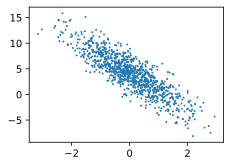

In [18]:
### 绘图工具，需要查找资料了解，plt.plot(x,y)...
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);  ###之前报错原因：安装d2l后重启机器，更换matplotlib版本


In [19]:
### 定义data_iter函数，该函数接受1.批量大小、2.特征矩阵、3.标签向量为输入，生成大小为batch_size的小批量
def data_iter(batch_size,features,labels):
  num_examples = len(features)                       ###数据长度
  indices = list(range(num_examples))                     ###以列表形式生成一系列数字，为索引
  random.shuffle(indices)                               ### 讲列表内数据随机打乱
  for i in range(0,num_examples,batch_size):                    ###从0到num_examples，每次跳batch_size个大小
    batch_indices = torch.tensor(indices[i:min(i + batch_size,num_examples)])   ### min() 避免最后一次超出序列
    yield features[batch_indices],labels[batch_indices]                ###yield如何理解？？？

batch_size = 10

for X,y in data_iter(batch_size,features,labels):               ##这里如何理解？
  print(X,'\n',y)
  break

tensor([[-1.6444, -0.9319],
        [-0.2513, -0.7595],
        [-0.3906, -0.7519],
        [ 0.4635,  1.4750],
        [-0.5328, -1.4084],
        [ 0.7335, -1.4123],
        [-0.0482,  0.1079],
        [ 0.1926, -1.0874],
        [-1.0856, -0.7025],
        [-0.6374,  0.1611]]) 
 tensor([[ 4.0939],
        [ 6.2766],
        [ 5.9703],
        [ 0.1216],
        [ 7.9236],
        [10.4635],
        [ 3.7339],
        [ 8.2875],
        [ 4.4143],
        [ 2.3607]])


In [20]:
### 定义初始化值  随机初始化
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

In [21]:
### 定义模型
def linreg(X,w,b):
  return torch.matmul(X,w)+b            ###线型回归模型


In [11]:
### 定义损失函数
def squared_loss(y_hat,y):
  return (y_hat - y.reshape(y_hat.shape))** 2 / 2   ###其中reshape是避免出现问题，理论上形状一致

In [22]:
### 定义优化算法
def sgd(params, lr, batch_size):     ### 1.给定的参数（w,b）2.学习率 3.batch_size
  with torch.no_grad():           ## 不需要计算梯度？？
    for param in params:              
      param -= lr * param.grad /batch_size ###参数减去学习率乘以该参数的梯度除以个数  其中均值未在损失函数就求得，所以需要在此除以个数来求得均值？？
      param.grad.zero_()                ### 梯度设置为0

In [23]:
### 训练函数
lr = 0.03                                 ### 学习率
num_epochs = 3                              ### 数据过三遍
net = linreg                               ### 相当于给函数加别名，方便更换网络
loss = squared_loss                           ### 与上面相同                
for epoch in range(num_epochs):
  for X,y in data_iter(batch_size,features,labels):          ### features是全数据集，每次选出一个batch_size的数据，分多次将所有数据过一遍
    l = loss(net(X,w,b),y)                      ### X和y的小批量损失，l是一个长度为批量大小的向量
    l.sum().backward()                         ### l为向量，所以在这里求和，此处backward求得了对w和b的偏导数？？
    sgd([w,b],lr,batch_size)                      ### 此处批量大小可能有问题，最后的数据可能没有一个完整批量
  with torch.no_grad():
    train_l = loss(net(features,w,b),labels)             ### 求损失 
    print(f'epoch {epoch +1},loss {float(train_l.mean()):f}')

epoch 1,loss 0.048549
epoch 2,loss 0.000205
epoch 3,loss 0.000050
